In [41]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_order, converge_ZNE_loocv, order_poly_ZNE, loocv_regularized_ZNE

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from samplers_util import thermal_rejection
from functions_util import calibrate_sim_Omegas, zero_temperature_Omega, cetina_envelope_exp, calibrate_Js


In [42]:
fig_1_data = np.load('figure_1_data.npz')
fig_2_data = np.load('Figure_2_data.npz')
fig_3_data = np.load('Figure_3b_data.npz')
fig_4_data = np.load('Figure_4_data.npz')
data_files = [fig_1_data, fig_2_data, fig_3_data, fig_4_data]
data_names=['Figure_1', 'Figure_2', 'Figure_3', 'Figure_4']
figure_index = 3
remove_first_val = [False, False, True, True][figure_index]
dataset = data_files[figure_index]
data_name = data_names[figure_index]


In [43]:
x = dataset['x']
y = dataset['y']
y_error = dataset['y_error']
y_ideal = dataset['y_ideal']
times = dataset['times']
print(x.shape)
print(x)
print(times.shape)
print('Should be ({}, {})'.format(x.shape[0], times.shape[0]))
print(y.shape)
print(y_error.shape)
print(y_ideal.shape)

assert y.shape == y_error.shape, 'y and y_error must have the same shape'
try:
    assert x.shape[0] == y.shape[1]
except:
    try:
        assert x.shape[0] == y.shape[0]
        y = y.T
        y_error = y_error.T
    except:
        pass

#Remove time point t=0 because it gives zero error. 
# if times[0] == 0:
#     times = times[1:]
#     y = y[1:]
#     y_error = y_error[1:]
#     y_ideal = y_ideal[1:]
#Replace any values of y_error which are within 1e-6 of zero with the minimum not zero:
print(np.min(y_error))
min_non_zero = np.min(y_error[np.where(y_error > 1e-6)])
y_error = np.where(y_error < 1e-6, min_non_zero, y_error)
#Replace all nan with min_non_zero:
y_error = np.where(np.isnan(y_error), min_non_zero, y_error)
#y_error = np.where(y_error < 1e-6, np.min(y_error[np.where(y_error > 1e-6)]), y_error)
#times = times[1:]
#y = y[1:]
#y_error = y_error[1:]
#y_ideal = y_ideal[1:]
print(np.min(y_error))


(6,)
[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058]
(30,)
Should be (6, 30)
(30, 6)
(30, 6)
(30,)
nan
0.02563722096326707


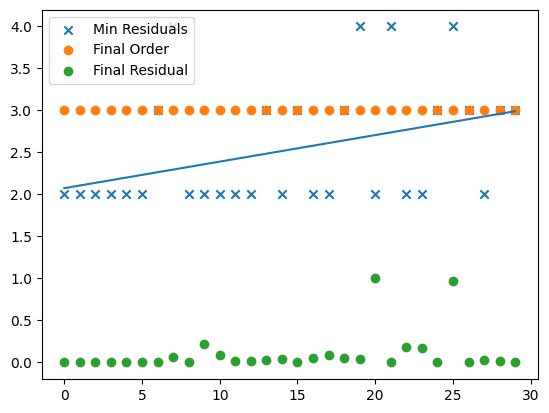

(6,)


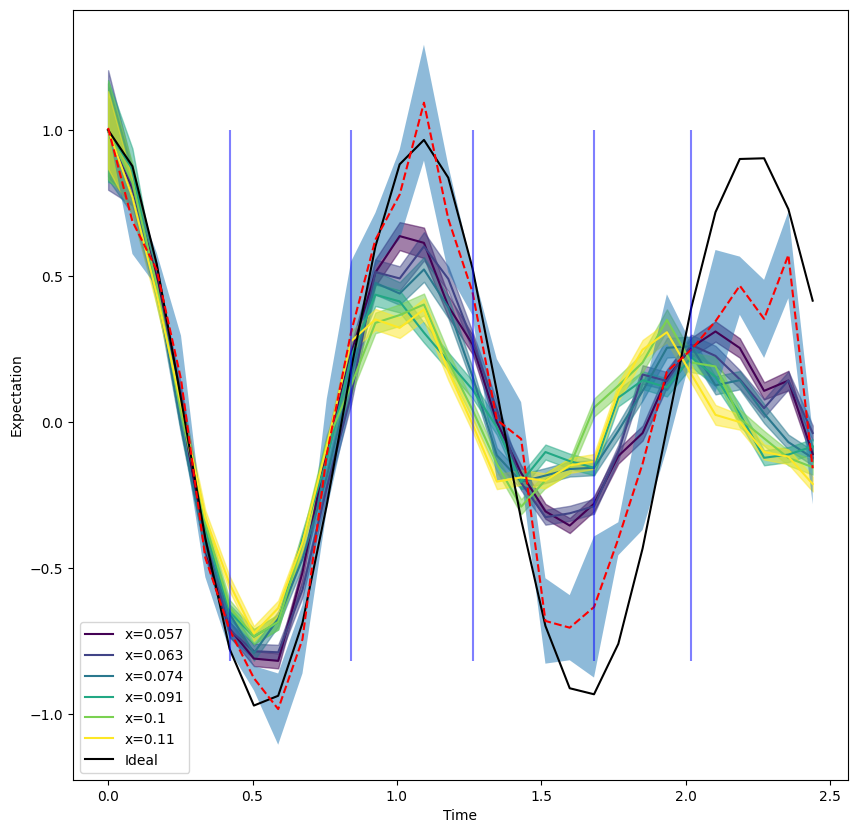

In [44]:

# = np.ones_like(y_error)*100
ZNE, ZNE_error, dict_results, residuals = loocv_regularized_ZNE(x, y, y_error, return_order=True, return_function=True, remove_first=remove_first_val, debug=True)
ZNE_functions = dict_results['functions']
ZNE_orders = dict_results['orders']
plt.show()

#make the figure tall:
plt.figure(figsize=(10, 10))
colors = cm.viridis(np.linspace(0, 1, len(x)))
for i in range(len(x)):
    plt.plot(times, y[:,i], color=colors[i], label=f'x={x[i]:.2g}')
    #Fill between:
    plt.fill_between(times, y[:,i] - y_error[:,i], y[:,i] + y_error[:,i], color=colors[i], alpha=0.5)
plt.plot(times, y_ideal, color='k', label='Ideal')
plt.xlabel('Time')
plt.ylabel('Expectation')
plt.legend()
print(x.shape)
plt.plot(times, ZNE, color='r', label='ZNE', linestyle='--')
plt.fill_between(times, ZNE - ZNE_error, ZNE + ZNE_error, alpha=0.5)

#Sample points:
samples = np.linspace(0, 1, 7)*len(times)
samples = [int(i) for i in samples[1:-1]]
for i in samples:
    plt.vlines(times[i], np.min(y), 1, color='b', alpha=0.5)

#Make the figure very tall:
plt.show()


In [45]:
dense_x = np.linspace(0, np.max(x), 1000)
dense_ZNE_function_data = np.zeros((len(times),len(dense_x)))
for i in range(len(times)):
    dense_ZNE_function_data[i] = ZNE_functions[i](dense_x)
np.savez('{}_full_data_ZNE.npz'.format(data_name), x=x, y=y, y_error=y_error, y_ideal=y_ideal, times=times, ZNE_results = ZNE, ZNE_error = ZNE_error, dense_x = dense_x, ZNE_y_dense = dense_ZNE_function_data)

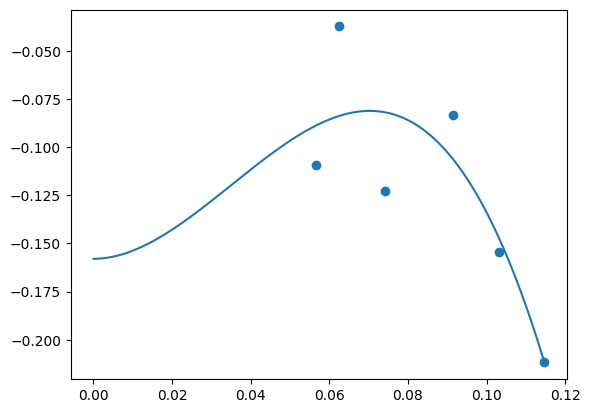

In [46]:
plt.scatter(x, y[-1])
plt.plot(dense_x, dense_ZNE_function_data[-1])

In [47]:
print(residuals)

[[3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01]
 [3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01 3.90057878e+01 3.90057878e+01
  3.90057878e+01 3.90057878e+01]
 [8.75480283e-09 1.68227553e-02 1.04397690e-03 1.21400859e-01
  4.

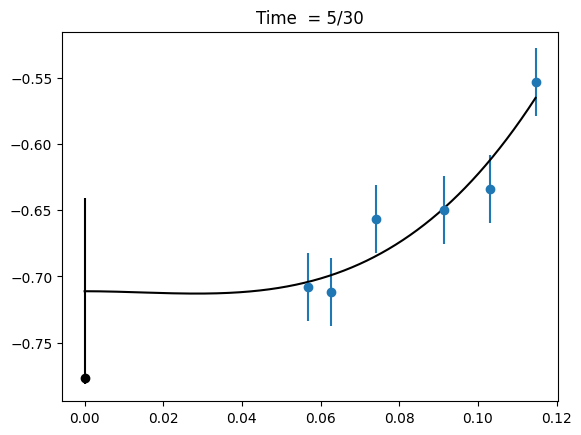

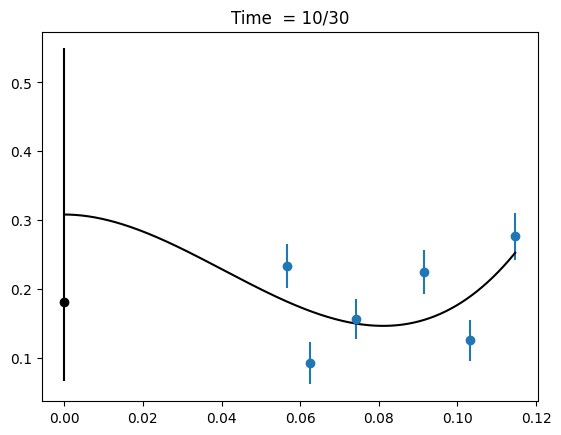

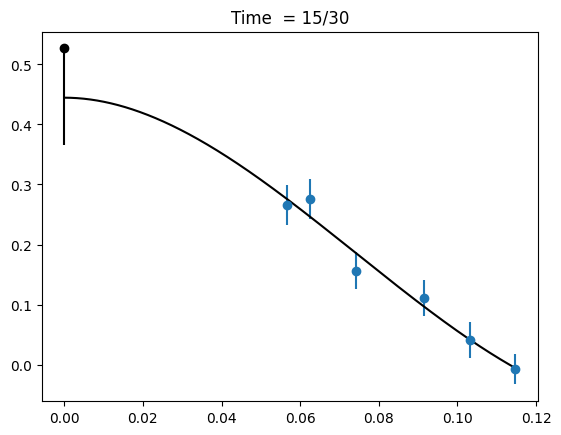

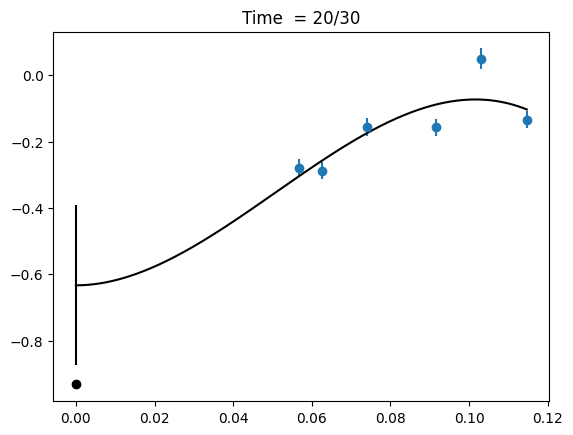

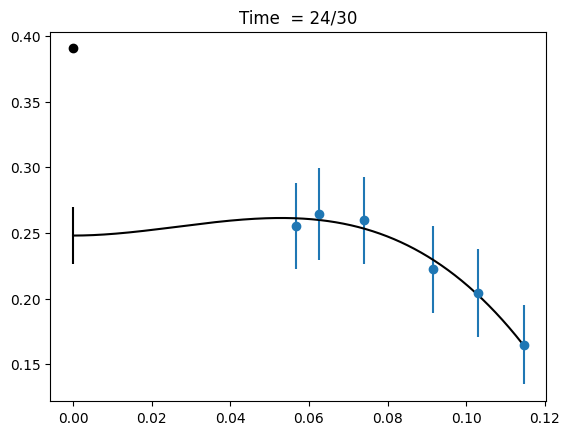

In [48]:
dense_x = np.linspace(0, np.max(x), 1000)
for i in samples:
    plt.errorbar(x, y[i,:], yerr=np.abs(y_error[i,:]), fmt='o', label='Data')
    plt.plot(dense_x, ZNE_functions[i](dense_x), color='k')
    plt.title('Time  = {}'.format('{}/{}'.format(i, len(times))))
    plt.errorbar(0, ZNE_functions[i](0), yerr=ZNE_error[i],color='k')
    plt.scatter(0, y_ideal[i],color='k')
    plt.show()

In [49]:
# print(residuals[:,82])
# plt.scatter(range(len(residuals[1:,82])), residuals[1:,82]) 
# #plt.ylim(0, residuals[1:,82])

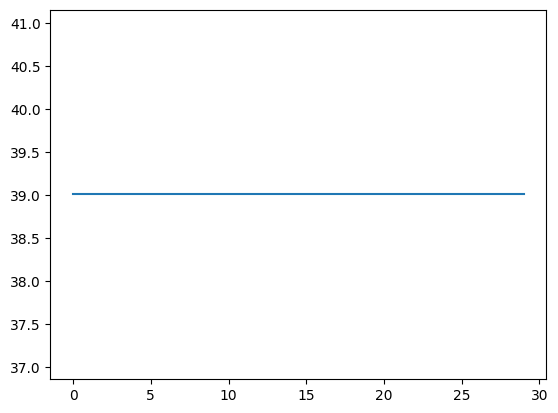

In [50]:
plt.plot(residuals[1])

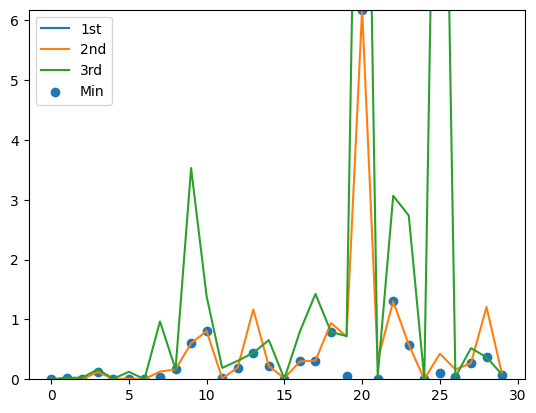

In [51]:
plt.plot(residuals[1], label='1st')
plt.plot(residuals[2], label='2nd')
plt.plot(residuals[3], label='3rd')
min_residuals = np.argmin(residuals, axis=0)
#get_min_residuals:
min_vals = np.min(residuals, axis=0)
#print(residuals[min_residuals])
plt.scatter(np.arange(len(residuals[0])), min_vals, label='Min')
plt.ylim(0, np.max(residuals[2]))
plt.legend()

